# Annotation of Tweets
In order to train a machine learning model we gathered ground truth data from a crowdsourcing task. Alternative to traditional gold standard data collection methods which employ expert annotaters and rely on single right answer for truth, we use an open-sourced crowdsourcing approach which relies on subjectivity the in human interpretations for gathering multiple annotations. The [CrowdTruth Framework](https://github.com/CrowdTruth/CrowdTruth) harnesses disagreement to yield higher quality results, rather than eliminating it.

Due to subjectivity in human interpretations of semantic data, disagreement between annotators is naturally produced as more people labeling natural language data. This is especially true in data that is inherently social, on microblogging sites such as Twitter. It is often not obvious in Tweets, which parts of speech are objects or subjects, and who is the intended audience. The inclusion of sarcasm, slang and hidden sentiment all produce ambiguity.

We gather multiple annotations per document, which reflects human subjectivity in the interpretations of each document. We then measure inter-annotator disagreement between each document and each annotaion, using the cosine-similarity measure within a vector space.

Specifically we are interested in gathering data on wether or not a tweet contains news about an event. This result is correlated with certain quality characteristics, also annotated for each tweet.

#### Quality Characteristics

- Advertisement
- Personal Opinion
- Direct Quote
- Sarcasm
- Explicit Language or Graphic Content
- Not in English
- Display Error
- None

#### News Update

- NOT CONTAINS: The Tweet does not contain any news about the Event
- POSSIBLY CONTAINS: The Tweet possibly contains news about the Event
- CONTAINS: The Tweet contains news about the Event

## Steps
1. Transform Raw Data
    - count total annotations per tweet
    - unstack html radio/checkbox values
2. Apply CrowdTruth Framework
    - get annotation vectors (worker-document vectors)
    - get unit vectors
    - get aggregate document vectors
    - **worker-document disagreement**
        - calculated as the average of all cosine distances between each worker's document vector and the aggregate document vector (minus that worker) [1]
        - sudo code:
            ``` python
            for each worker:
                get worked documents
                compute document vectors minus worker
                for every other worker:
                    get worker document score as cosine distance(worker vector, document vector minus worker)
            get worker score as avg(worker document scores)
            ```
    - **worker-worker disagreement**
        - calculated as $1 - avg(k)$ where k is the pairwise metric, between every worker vector and all other worker vectors [1]
        - sudo code: 
            ``` python
            for each worker:
                for every other worker:
                    get documents overlap
                    for document in documents overlap:
                        for annotation in annotations vector:
                            get agreement
                    get worker worker document score as sum (agreement) / total annotations
            get worker score as 1 - avg(worker worker document scores)
            ```
    - **document-annotation scores** (vector)
        - calculated as the cosine distance between the each aggregate document vector and the unit vector for every annotation [1]
    - **document clarity**
        - calculated as the max annotation score for each document [1]
3. Aggregate
    - remove spam workers
        - if outlier in both worker-worker disagrmeent and worker-document disagreement
    - take those annotaions with >= .85 clarity
        - Following the CrowdTruth results demonstrated in [1], we select a threshold for document clarity that yeilds highest agreement between crowd and experts. They showed that the higher this score, the easier it is for a machine as well as human to classify.
4. Summarize
    - identify correlations between news annotations with certain quality characteristic
    - identify relationships between annotations and clarity
    

## CrowdTruth Framework:
The framework's metrics exploit ambiguity in annotations for collecting higher quality annotations. The example below considers two documents (Tweets), each being annotated by three workers. 

**annotation vectors**
- the annotation of one worker for one document

| doc | worker | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|---|
| 101 | 001 | 0 | 0 | 1 |
| 101 | 002 | 0 | 1 | 0 |
| 101 | 003 | 0 | 0 | 1 |
| 102 | 001 | 1 | 0 | 0 |
| 102 | 002 | 1 | 0 | 0 |
| 102 | 003 | 0 | 1 | 0 |
| 103 | 001 | 1 | 0 | 0 |
| 103 | 002 | 0 | 1 | 0 |
| 103 | 003 | 0 | 1 | 0 |

**document vectors**
- for every sentence, the sum of all annotation vectors

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0 | 1 | 2 |
| 102 | 2 | 1 | 0 |
| 103 | 1 | 2 | 0 |

**unit vectors**
- for every sentence, the sum of all annotation vectors

| annotation | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| NOT CONTAINS | 1 | 0 | 0 |
| POSSIBLY CONTAINS | 0 | 1 | 0 |
| CONTAINS | 0 | 0 | 1 |

**worker-document scores**

| worker | doc | worker_document_score |
|---|---|---|
| 001 | 101 | 0.71 |
| 001 | 102 | 0.71 |
| 001 | 103 | 0.00 |
| 002 | 101 | 0.00 |
| 002 | 102 | 0.71 |
| 002 | 103 | 0.71 |
| 003 | 101 | 0.71 |
| 003 | 102 | 0.00 |
| 003 | 103 | 0.71 |

| worker | avg_worker_document_score |
|---|---|
| 001 | 0.47 |
| 002 | 0.47 |
| 003 | 0.47 |

**worker-worker scores**

$k = agreement / annotations$

| worker1 | worker2 | doc | k |
|---|---|---|---|
| 001 | 002 | 101 | 0.00 |
| 001 | 002 | 102 | 0.33 |
| 001 | 002 | 103 | 0.00 |
| 001 | 003 | 101 | 0.33 |
| 001 | 003 | 102 | 0.00 |
| 001 | 003 | 103 | 0.00 |
| 002 | 001 | 101 | 0.00 |
| 002 | 001 | 102 | 0.33 |
| 002 | 001 | 103 | 0.00 |
| 002 | 003 | 101 | 0.00 |
| 002 | 003 | 102 | 0.00 |
| 002 | 003 | 103 | 0.33 |
| 003 | 001 | 101 | 0.33 |
| 003 | 001 | 102 | 0.00 |
| 003 | 001 | 103 | 0.00 |
| 003 | 002 | 101 | 0.00 |
| 003 | 002 | 102 | 0.00 |
| 003 | 002 | 103 | 0.33 |

$disagreement = (1 - avg(k))$

| worker | worker_worker_disagreement |
|---|---|
| 001 | 0.81 |
| 002 | 0.81 |
| 003 | 0.81 |

**document-annotation scores**
- the cosine similarity between the document vector and the unit vector for that annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0.00 | 0.45 | 0.89 |
| 102 | 0.89 | 0.45 | 0.00 |
| 103 | 0.45 | 0.89 | 0.00 |

**document clarity**
- the scores are a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0.00 | 0.00 | 0.89 |
| 102 | 0.89 | 0.00 | 0.00 |
| 103 | 0.00 | 0.89 | 0.00 |

### Citations
[1] [Anca Dumitrache, Lora Aroyo, Chris Welty: Achieving Expert-Level Annotation Quality with CrowdTruth: The Case of Medical Relation Extraction. BDM2I at ISWC 2015.](http://www.ancad.ro/2015/08/14/achieving-expert-level-annotation-quality-with-crowdtruth/)

[2] [Aroyo, Chris Welty: The Three Sides of CrowdTruth. J. Human Computation. 1(1). 2014.](http://hcjournal.org/ojs/index.php?journal=jhc&page=article&op=view&path%5B%5D=34&path%5B%5D=8Lora)


#### import tools

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.metrics.pairwise import cosine_similarity

#### import annotation data

In [238]:
#MANUAL TEST
#cf = pd.read_csv('data/final/cf_report_FINAL_manual.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
#MANUAL TEST

cf = pd.read_csv('data/final/cf_report_crowdtest100.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})

In [239]:
cf.rename(columns={'_unit_id' : 'document_id', '_id' : 'annotation_id', '_worker_id' : 'worker_id'}, inplace=True)
#cf.drop_duplicates(subset=[['document_id', 'worker_id']], inplace=True, keep='last')
cf.sort_values(by=['event', 'event_id', 'text'], inplace=True)

# 1. Transform
- NOTE: i use combination of own keys ['event', 'event_id'] instead of 'annotation id' ...to ensure accuracy
- can be replaced for future

In [240]:
print('crowdsourced:')
print('%s unique annotations' % cf['annotation_id'].unique().shape[0])
print('%s unique tweets annotated' % cf.groupby(['event', 'event_id']).size().shape[0])

crowdsourced:
652 unique annotations
100 unique tweets annotated


#### count total annotations per tweet

In [241]:
cf_annpertweet = pd.DataFrame(cf.groupby('document_id')['worker_id'].count())
cf_annpertweet.columns = ['doc_annotations']
cf_annpertweet.reset_index(inplace=True)
cf = pd.merge(cf, cf_annpertweet, how='left', on=['document_id'])

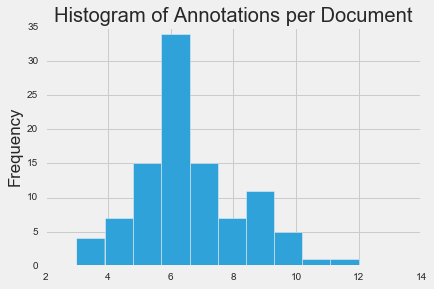

In [242]:
cf.groupby(['document_id']).size().plot(kind='hist', title='Histogram of Annotations per Document')
plt.show()

#### unstack html radio/checkbox values
- decode "news" to annotation values

In [243]:
annotation_codes = {0.0 : 'NOT CONTAINS',
                    0.5 : 'POSSIBLY CONTAINS',
                    1.0 : 'CONTAINS'}

annotations  = list(annotation_codes.values())

In [244]:
cf['news'].replace(annotation_codes, inplace=True)

for ann in annotations:
    cf[ann] = cf['news'].apply(lambda a: [0,1][a == ann])

# 2. Apply CrowdTruth Framework
### annotation vectors
- using [event, event_id] as unique doc id's
- because integrity of twitter_id was lost (CrowdFlower could not handle)

In [245]:
cols = ['document_id', 'worker_id']
cols.extend(annotations)
anno_vectors = cf[cols]
anno_vectors.set_index(['document_id', 'worker_id'], inplace=True)
anno_vectors.sort_index(inplace=True)
anno_vectors.head()

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NOT CONTAINS  POSSIBLY CONTAINS  CONTAINS
document_id worker_id                                           
962954621   29559144              1                  0         0
            31821164              0                  1         0
            32231403              0                  1         0
            32231403              0                  1         0
            37814681              0                  0         1

## worker-document score

In [246]:
%%time
#pandas sclicing
idx = pd.IndexSlice

workers = anno_vectors.index.get_level_values('worker_id').unique()
worker_doc_scores = pd.DataFrame()

for worker in workers:
    #get list workers minus worker
    workers_minworker = [w for w in workers if w != worker]
    #get docs worker worked on
    worker_docs = anno_vectors.loc[idx[:,worker],:].index.get_level_values('document_id').unique()
    #compute aggregate document vectors including all workers minus worker
    doc_vectors_minworker = anno_vectors.loc[idx[worker_docs,workers_minworker],:].groupby(level=('document_id')).sum()
    for document in worker_docs:
        worker_doc_vector = anno_vectors.loc[idx[document,worker],:]
        doc_vector_minworker = doc_vectors_minworker.loc[document]
        #compute distance
        score = cosine_similarity(worker_doc_vector, [doc_vector_minworker])
        #transform to table row
        row = pd.Series([document, worker, score[0][0]], index=['document_id', 'worker_id', 'score'])
        worker_doc_scores = worker_doc_scores.append(row, ignore_index=True)

#average doc scores per worker
worker_doc_scores = pd.DataFrame(worker_doc_scores.groupby('worker_id')['score'].mean())

Wall time: 2.53 s


#### plot distribution

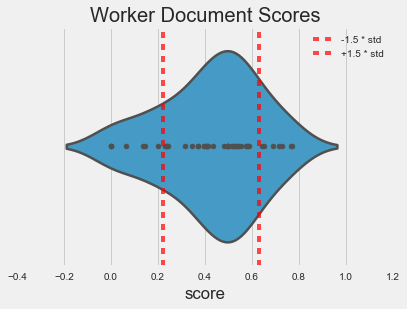

In [247]:
mean = std = worker_doc_scores['score'].mean()
std = worker_doc_scores['score'].std()

ax = sns.violinplot(data=worker_doc_scores, x='score', orient='h', inner='point', linewidth=2.5)
ax.axvline(x=mean - 1 * std, linestyle='--', c='r', alpha=.70, label='-1.5 * std')
ax.axvline(x=mean + 1 * std, linestyle='--', c='r', alpha=.70, label='+1.5 * std')
plt.title('Worker Document Scores')
plt.legend(loc='best')
plt.show()

## worker-worker score

In [248]:
%%time
#sort indexes for sclicing
anno_vectors.sort_index(inplace=True)
idx = pd.IndexSlice

workers = anno_vectors.index.get_level_values('worker_id').unique()
worker_worker_scores = pd.DataFrame()

for worker1 in workers:
    #get list workers minus worker
    workers_minworker = [w for w in workers if w != worker1]
    #get docs worker worked on
    worker1_docs = anno_vectors.loc[idx[:,worker1],:].index.get_level_values('document_id').unique()
    for worker2 in workers_minworker:
        #get docs worker worked on
        worker2_docs = anno_vectors.loc[idx[:,worker2],:].index.get_level_values('document_id').unique()
        #get overlapping docs
        docs_overlapped = [doc for doc in worker1_docs if doc in worker2_docs]
        for document in docs_overlapped:
            #get annotation vectors for each worker
            worker1_doc = anno_vectors.loc[idx[document,worker1],:]
            worker2_doc = anno_vectors.loc[idx[document,worker2],:]
            worker1_total_annotations = 0
            agreement = 0
            for anno in annotations:
                #count annotations
                worker1_total_annotations += worker1_doc.iloc[0][anno] 
                #get agreement
                agreement += min(worker1_doc.iloc[0][anno], worker2_doc.iloc[0][anno])        
        #get worker worker document score as sum (agreement) / total annotations
        score = agreement / worker1_total_annotations
        #transform to table row
        row = pd.Series([document, worker1, worker2, score], index=['document_id', 'worker1_id', 'worker2_id', 'score'])
        worker_worker_scores = worker_worker_scores.append(row, ignore_index=True)

#average worker doc scores per worker
worker_worker_scores = 1 - pd.DataFrame(worker_worker_scores.groupby('worker1_id')['score'].mean())

Wall time: 15.1 s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### plot distribution

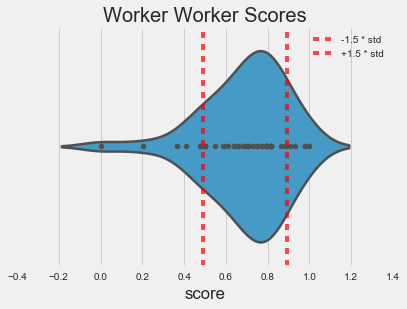

In [249]:
mean = std = worker_worker_scores['score'].mean()
std = worker_worker_scores['score'].std()

ax = sns.violinplot(data=worker_worker_scores, x='score', orient='h', inner='point', linewidth=2.5)
ax.axvline(x=mean - 1 * std, linestyle='--', c='r', alpha=.70, label='-1.5 * std')
ax.axvline(x=mean + 1 * std, linestyle='--', c='r', alpha=.70, label='+1.5 * std')
plt.title('Worker Worker Scores')
plt.legend(loc='best')
plt.show()

### id outliers

In [253]:
multiplier = 1

In [254]:
wd_out = worker_doc_scores[(worker_doc_scores['score'] < worker_doc_scores['score'].mean() - multiplier * worker_doc_scores['score'].std())
                    | (worker_doc_scores['score'] > worker_doc_scores['score'].mean() + multiplier * worker_doc_scores['score'].std())].index

ww_out = worker_worker_scores[(worker_worker_scores['score'] < worker_worker_scores['score'].mean() - multiplier * worker_worker_scores['score'].std())
                    | (worker_worker_scores['score'] > worker_worker_scores['score'].mean() + multiplier * worker_worker_scores['score'].std())].index

In [255]:
workers_out = [worker for worker in wd_out if worker in ww_out]

In [234]:
#anno_vectors.loc[idx[:,workers_out],:]

#### drop outliers

In [256]:
cf = cf[cf['worker_id'].isin(workers_out) == False]
cf.shape

(627, 148)

In [257]:
anno_vectors.drop(workers_out, level='worker_id', inplace=True)
anno_vectors.shape

(627, 3)

### document vectors

In [258]:
doc_vectors = anno_vectors.reset_index().groupby('document_id')[annotations].sum()
doc_vectors.sort_index(inplace=True)
doc_vectors.head()

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
document_id,,,
962954621,2,3,0
962954622,0,4,3
962954623,2,1,1
962954624,0,5,2
962954625,3,1,1


### unit vectors
- construct square matrix, of unit verctors
- where diagonal to 1

In [259]:
a = np.zeros([len(annotations), len(annotations)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=annotations, columns=annotations)
unit_vectors

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
NOT CONTAINS,1.0,0.0,0.0
POSSIBLY CONTAINS,0.0,1.0,0.0
CONTAINS,0.0,0.0,1.0


## document-annotation score
- compute the cosine similarity between each document vector and the unit vector for every annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$

In [260]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=annotations)
doc_anno_scores.head()

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
0,0.554700,0.832050,0.000000
1,0.000000,0.800000,0.600000
2,0.816497,0.408248,0.408248
3,0.000000,0.928477,0.371391
4,0.904534,0.301511,0.301511


#### plot distribution

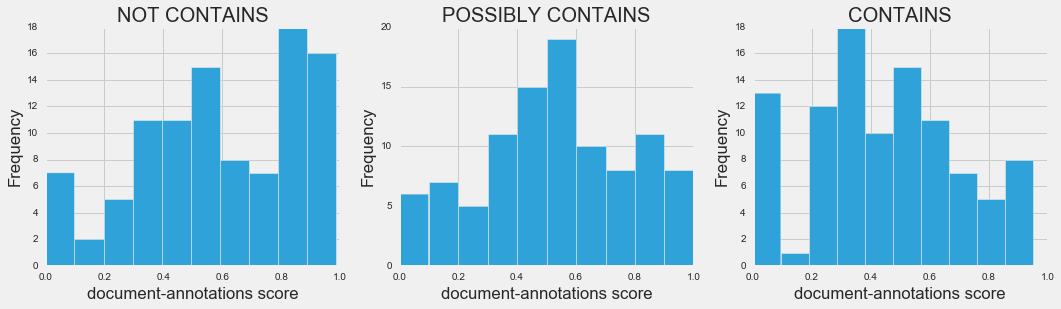

In [261]:
fig, axs = plt.subplots(1,len(annotations), figsize=(16, 4))
for i,ann in enumerate(doc_anno_scores.columns):
    axs[i].hist(doc_anno_scores[ann])
    axs[i].set_title(ann)
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('document-annotations score')
plt.show()

## clarity scores
- maximum document-annotation score
- the score is a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine

In [262]:
clarity_scores = doc_anno_scores.apply(lambda row: [row[anno] if row[anno] == row.max() else 0 for anno in annotations], axis=1)

#### visualize

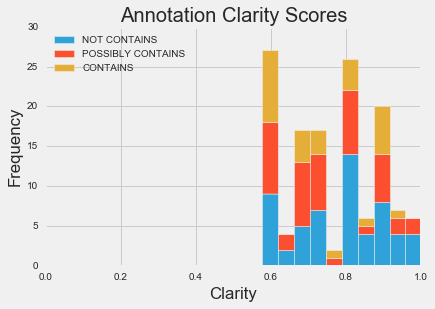

In [263]:
ax = clarity_scores[clarity_scores != 0].plot(kind='hist', stacked=True, alpha=1)
ax.set_xlim(0,1)
ax.set_title('Annotation Clarity Scores')
ax.set_xlabel('Clarity')
plt.show()

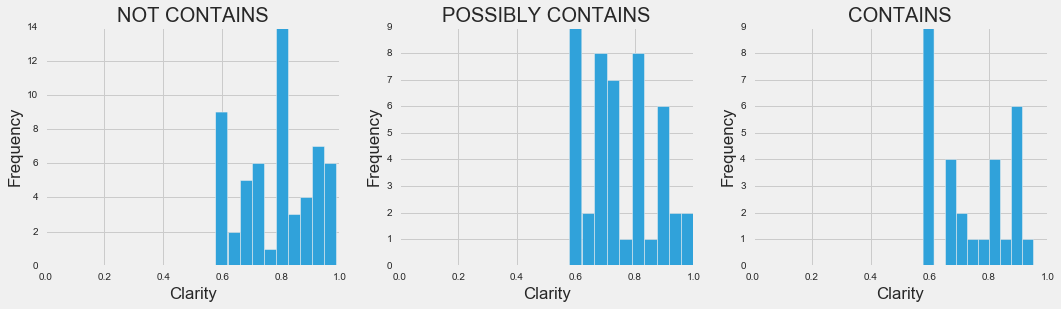

In [264]:
fig, axs = plt.subplots(1, len(annotations), figsize=(16, 4))
for i,ann in enumerate(annotations):
    clarity_scores[clarity_scores != 0][ann].plot(ax=axs[i], kind='hist')
    axs[i].set_xlim(0,1)
    axs[i].set_title(ann)
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Clarity')
plt.show()

#### merge scores to data

In [265]:
#doc_anno_scores.columns = [ann+' clarity' for ann in annotations]
clarity_scores.columns = [ann+' clarity' for ann in annotations]

In [266]:
#anno_results = pd.merge(doc_vectors.reset_index(), doc_anno_scores, left_index=True, right_index=True)
anno_results = pd.merge(doc_vectors.reset_index(), clarity_scores, left_index=True, right_index=True)
anno_results.head()

,document_id,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS,NOT CONTAINS clarity,POSSIBLY CONTAINS clarity,CONTAINS clarity
0,962954621,2,3,0,0.000000,0.832050,0.0
1,962954622,0,4,3,0.000000,0.800000,0.0
2,962954623,2,1,1,0.816497,0.000000,0.0
3,962954624,0,5,2,0.000000,0.928477,0.0
4,962954625,3,1,1,0.904534,0.000000,0.0


#### merge results to tweet data

In [267]:
anno_results = pd.merge(cf[['document_id', 'event', 'event_id', 'text']].drop_duplicates(), anno_results, how='right', on='document_id')

#### plot annotation clarity

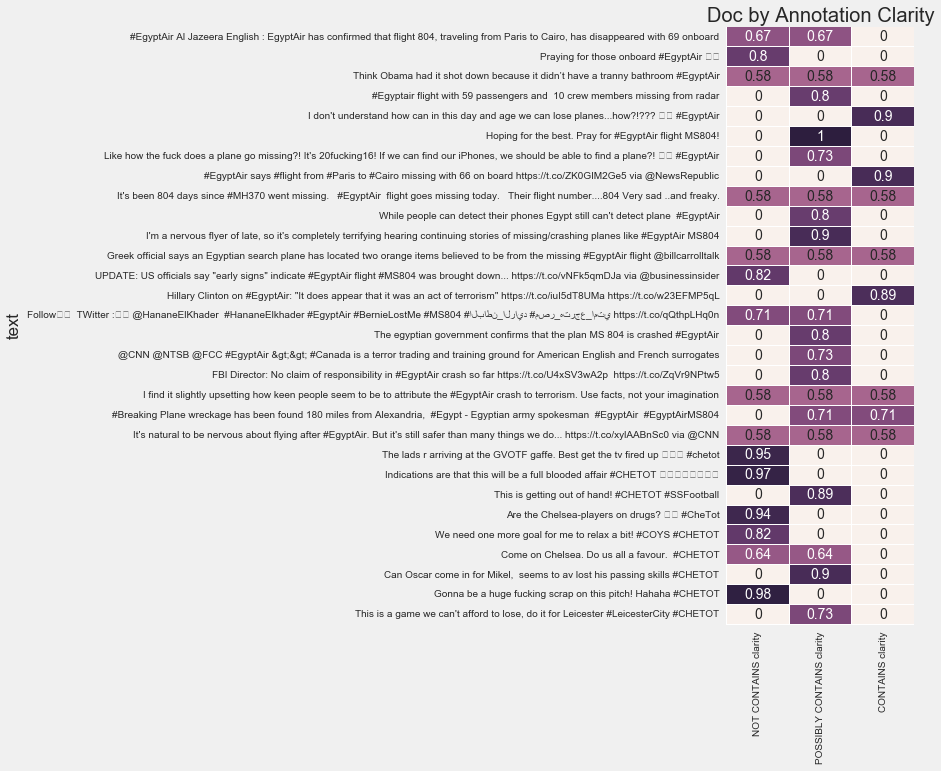

In [268]:
x = anno_results.set_index('text')[clarity_scores.columns].head(30)
plt.figure(figsize=(3, 10))
ax = sns.heatmap(x, annot=True, linewidths=.01, cbar=False)
sns.plt.title('Doc by Annotation Clarity')
plt.show()

## Compare to Manually Annotated (Strict)

#### News
- import manually annotated
- merge crowd annotations with expert
- export this data (for manual analysis in excel)

In [269]:
cf_man = pd.read_csv('data/final/cf_report_manualtest100.csv', sep=',', encoding='utf-8', header=0)
cf_man.sort_values(by=['event', 'event_id', 'text'], inplace=True)
cf_man.shape

(100, 69)

In [270]:
print('expert:')
print('%s unique annotations' % cf_man['id'].unique().shape[0])
print('%s unique tweets annotated' % cf_man.groupby(['event', 'event_id']).size().shape[0])

expert:
100 unique annotations
100 unique tweets annotated


In [271]:
cf_man['news'].replace(annotation_codes, inplace=True)

for ann in annotations:
    cf_man[ann] = cf_man['news'].apply(lambda a: [0,1][a == ann])

In [272]:
anno_results_crowd = anno_results.set_index(['event', 'event_id', 'text'])
anno_results_manual = cf_man.set_index(['event', 'event_id', 'text'])[annotations]

anno_results_out = pd.merge(anno_results_crowd, anno_results_manual, left_index=True, right_index=True)

anno_results_out.to_csv('annotation_results.txt', sep='\t')

## 2.5 Apply Clarity Scores to Characteristics

In [273]:
characteristics = ['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']

for char in characteristics:
    cf[char] = cf['characteristics'].apply(lambda q: 1 if char in [i for i in str(q).split('\n')] else 0)

#### document vectors

In [274]:
#doc_vectors = cf.groupby(['event', 'event_id', 'text', 'doc_annotations'])[characteristics].sum()
doc_vectors = cf.groupby('document_id')[characteristics].sum()
doc_vectors.sort_index(inplace=True)
doc_vectors.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
document_id,,,,,,,,
962954621,1,4,2,2,1,0,0,0
962954622,0,6,0,1,0,0,0,0
962954623,1,4,1,1,1,0,0,0
962954624,0,6,1,1,0,0,0,0
962954625,0,2,2,2,0,1,0,0


#### unit vectors

In [275]:
a = np.zeros([len(characteristics), len(characteristics)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=characteristics, columns=characteristics)
unit_vectors

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
question,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
advertisement,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
opinion,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
quote,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
sarcasm,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
explicit,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
lang,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### document-annotation scores

In [276]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=characteristics)
doc_anno_scores.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
0,0.196116,0.784465,0.392232,0.392232,0.196116,0.00000,0.0,0.0
1,0.000000,0.986394,0.000000,0.164399,0.000000,0.00000,0.0,0.0
2,0.223607,0.894427,0.223607,0.223607,0.223607,0.00000,0.0,0.0
3,0.000000,0.973329,0.162221,0.162221,0.000000,0.00000,0.0,0.0
4,0.000000,0.554700,0.554700,0.554700,0.000000,0.27735,0.0,0.0


#### clarity scores

In [277]:
clarity_scores = doc_anno_scores.apply(lambda row: [row[char] if row[char] == row.max() else 0 for char in characteristics], axis=1)
clarity_scores.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
0,0.0,0.784465,0.0000,0.0000,0.0,0.0,0.0,0.0
1,0.0,0.986394,0.0000,0.0000,0.0,0.0,0.0,0.0
2,0.0,0.894427,0.0000,0.0000,0.0,0.0,0.0,0.0
3,0.0,0.973329,0.0000,0.0000,0.0,0.0,0.0,0.0
4,0.0,0.554700,0.5547,0.5547,0.0,0.0,0.0,0.0


#### visualize

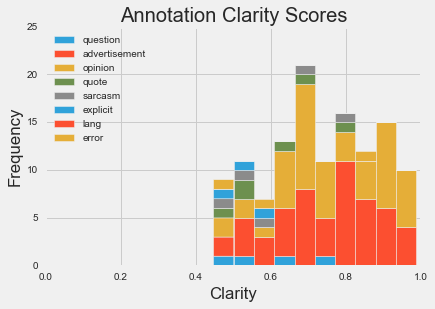

In [278]:
ax = clarity_scores[clarity_scores != 0].plot(kind='hist', stacked=True, alpha=1)
ax.set_xlim(0,1)
ax.set_title('Annotation Clarity Scores')
ax.set_xlabel('Clarity')
plt.show()

#### merge scores to data

In [284]:
doc_anno_scores.columns = [ann+' clarity' for ann in characteristics]
char_results = pd.merge(doc_vectors.reset_index(), doc_anno_scores, left_index=True, right_index=True)
char_results.head()

,document_id,question,advertisement,opinion,quote,sarcasm,explicit,lang,error,question clarity,advertisement clarity,opinion clarity,quote clarity,sarcasm clarity,explicit clarity,lang clarity,error clarity
0,962954621,1,4,2,2,1,0,0,0,0.196116,0.784465,0.392232,0.392232,0.196116,0.00000,0.0,0.0
1,962954622,0,6,0,1,0,0,0,0,0.000000,0.986394,0.000000,0.164399,0.000000,0.00000,0.0,0.0
2,962954623,1,4,1,1,1,0,0,0,0.223607,0.894427,0.223607,0.223607,0.223607,0.00000,0.0,0.0
3,962954624,0,6,1,1,0,0,0,0,0.000000,0.973329,0.162221,0.162221,0.000000,0.00000,0.0,0.0
4,962954625,0,2,2,2,0,1,0,0,0.000000,0.554700,0.554700,0.554700,0.000000,0.27735,0.0,0.0


#### merge scores to tweet data

In [285]:
char_results = pd.merge(cf[['document_id', 'event', 'event_id', 'text']].drop_duplicates(), char_results, how='right', on='document_id')

## 3. Aggregate Annotations
### News
- using clarity score
- take that annotation which is greater than .85
    - if annotation > .85 then 1 else 0
- in cases where no annotations were > .85
    - these ambigous cases are excluded from the training data

In [322]:
anno_results['news agg'] = np.nan
#anno_results['news agg'] = anno_results.apply(lambda row: [0,1][row['CONTAINS clarity'] >= .85], axis=1)
anno_results['news agg'][anno_results['NOT CONTAINS clarity'] >= .85] = 0
anno_results['news agg'][anno_results['CONTAINS clarity'] >= .85] = 1

anno_results_agg = anno_results[anno_results['news agg'].isnull() == False][['event', 'event_id', 'news agg']]
anno_results_agg.columns = ['event', 'event_id', 'news']

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Characteristics
- using majority vote

In [ ]:
#char_results['question agg'] = char_results.apply(lambda row: [0,1][row['question'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['advertisement agg'] = char_results.apply(lambda row: [0,1][row['advertisement'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['opinion agg'] = char_results.apply(lambda row: [0,1][row['opinion'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['quote agg'] = char_results.apply(lambda row: [0,1][row['quote'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['sarcasm agg'] = char_results.apply(lambda row: [0,1][row['sarcasm'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['explicit agg'] = char_results.apply(lambda row: [0,1][row['explicit'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['lang agg'] = char_results.apply(lambda row: [0,1][row['lang'] > (row['doc_annotations'] / 2)] , axis=1)
#char_results['error agg'] = char_results.apply(lambda row: [0,1][row['error'] > (row['doc_annotations'] / 2)] , axis=1)

In [311]:
char_results['question agg'] = 0
char_results['question agg'][char_results['question clarity'] > .85] = 1
char_results['advertisement agg'] = 0
char_results['advertisement agg'][char_results['advertisement clarity'] > .85] = 1
char_results['opinion agg'] = 0
char_results['opinion agg'][char_results['opinion clarity'] > .85] = 1
char_results['quote agg'] = 0
char_results['quote agg'][char_results['quote clarity'] > .85] = 1
char_results['sarcasm agg'] = 0
char_results['sarcasm agg'][char_results['sarcasm clarity'] > .85] = 1
char_results['explicit agg'] = 0
char_results['explicit agg'][char_results['explicit clarity'] > .85] = 1
char_results['lang agg'] = 0
char_results['lang agg'][char_results['lang clarity'] > .85] = 1
char_results['error agg'] = 0
char_results['error agg'][char_results['error clarity'] > .85] = 1

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [325]:
char_results_agg = char_results[['event', 'event_id', 'question agg', 'advertisement agg', 'opinion agg', 'quote agg', 'sarcasm agg', 'explicit agg', 'lang agg', 'error agg']]
cols = ['event', 'event_id']
cols.extend(characteristics)
char_results_agg.columns = cols

#### merge aggregate annotations

In [328]:
cf_agg = pd.merge(anno_results_agg, char_results_agg, how='inner', on=['event', 'event_id'])
cf_agg.shape

(26, 11)

#### export aggregate annotaions

In [ ]:
cf_agg.to_csv('data/final/tweet_annotations_agg_FINAL_manual.csv', sep='\t', encoding='utf-8', header=True, index=False)

## 4. Summarize
- high level summary

#### add none (characteristics) column

In [329]:
cf_agg['none'] = cf_agg.apply(lambda x: [0,1][x[characteristics].sum() == 0], axis=1)

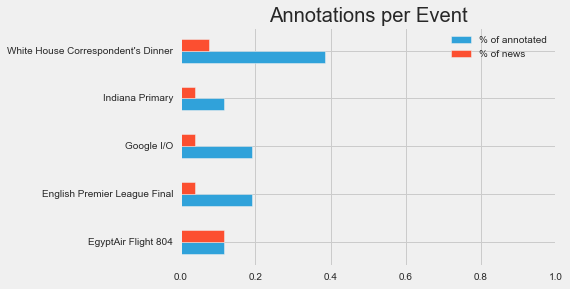

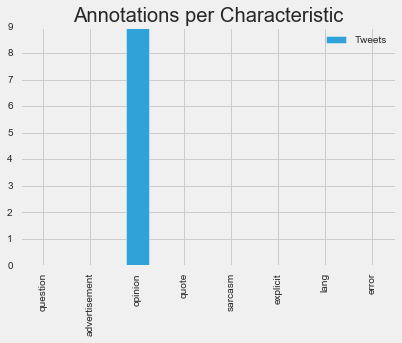

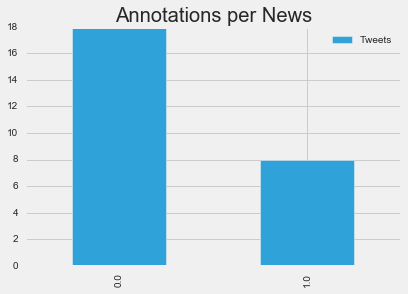

In [330]:
d1 = cf_agg.reset_index()['event'].value_counts(normalize=True)
d2 = cf_agg.reset_index().groupby('event')['news'].sum() / cf_agg.shape[0]
d = pd.merge(pd.DataFrame(d1), pd.DataFrame(d2), left_index=True, right_index=True)
d.columns = ['% of annotated', '% of news']
d.plot(kind='barh', xlim=[0,1], title='Annotations per Event')
plt.show()

d = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].apply(pd.Series.value_counts).iloc[1]
d.plot(kind='bar', title='Annotations per Characteristic', label='Tweets')
plt.legend(loc='best')
plt.show()

d = cf_agg['news'].value_counts()
d.plot(kind='bar', title='Annotations per News', label='Tweets')
plt.legend(loc='best')
plt.show()

- in depth summary

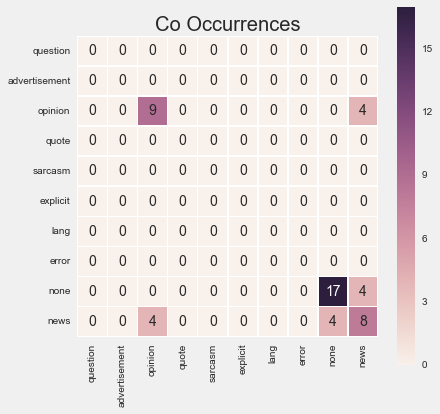

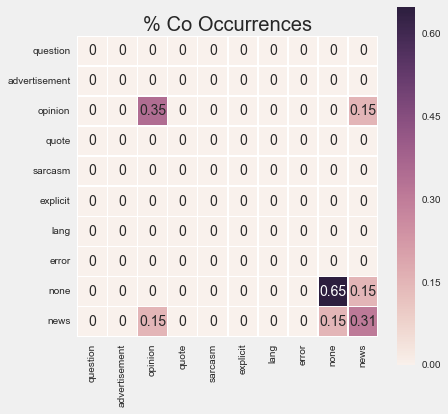

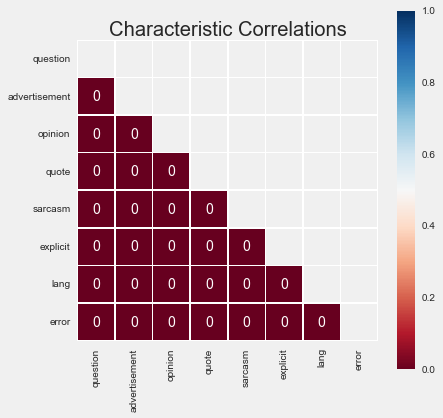

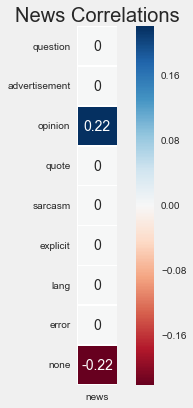

In [331]:
x = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none', 'news']]

plt.figure(figsize=(6,6))
ax = sns.heatmap((x.T.dot(x)), annot=True, square=True, linewidths=.5)
plt.title('Co Occurrences')
sns.plt.show()

plt.figure(figsize=(6,6))
ax = sns.heatmap(round(x.T.dot(x) / cf_agg.shape[0], 2), annot=True, square=True, linewidths=.5)
plt.title('% Co Occurrences')
sns.plt.show()

xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].corr()
mask = np.full(xcorr.shape, False, dtype=bool)
mask[np.triu_indices(len(xcorr))] = True
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, mask=mask, cmap='RdBu', linewidths=.5)
plt.title('Characteristic Correlations')
sns.plt.show()

xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
xcorr = pd.DataFrame(xcorr, columns=['news'])
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
plt.title('News Correlations')
sns.plt.show()

#### apply event types

In [332]:
event_types = {'Champions League Final' : 'Sporting',
               'Monaco Grand Prix' : 'Sporting',
               'The French Open' : 'Sporting',
               'Recode Code Conference' : 'Tech Conference',
               'Converge Asia' : 'Tech Conference',
               'The Next Web Conference Europe' : 'Tech Conference'}

cf_agg['event_type'] = cf_agg['event']
cf_agg['event_type'].replace(event_types, inplace=True)

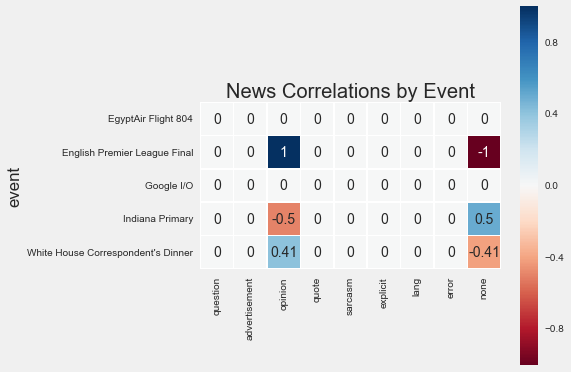

In [333]:
xcorr = cf_agg.groupby('event')[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
plt.title('News Correlations by Event')
sns.plt.show()

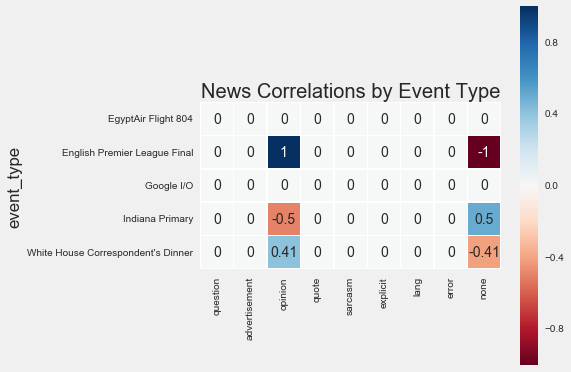

In [334]:
xcorr = cf_agg.groupby('event_type')[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
#xcorr = xcorr.reset_index().groupby('event_type').mean()
plt.figure(figsize=(6,6))
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
plt.title('News Correlations by Event Type')
sns.plt.show()